# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Neha Malhotra

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [219]:
# Install required libraries (will install if not already installed)
!pip install tensorflow keras matplotlib seaborn scikit-learn pandas numpy --quiet

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential  # Use tensorflow's keras
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set up visualization style
sns.set_style("darkgrid")

print("Libraries imported successfully and environment is set up!")

Libraries imported successfully and environment is set up!


In [221]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

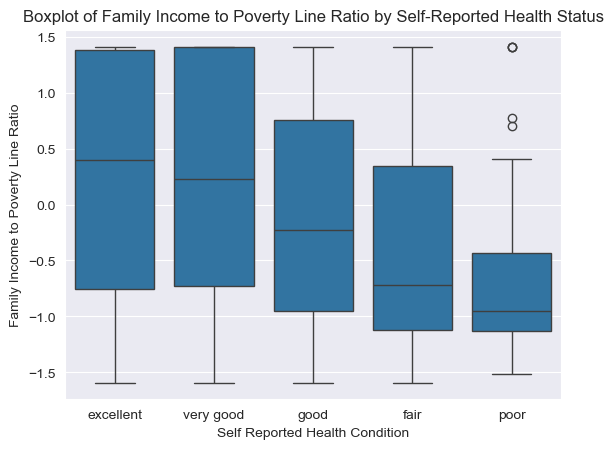

In [223]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

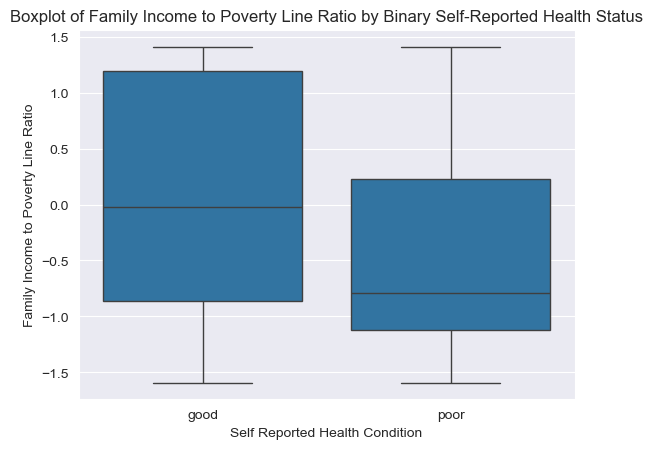

In [225]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

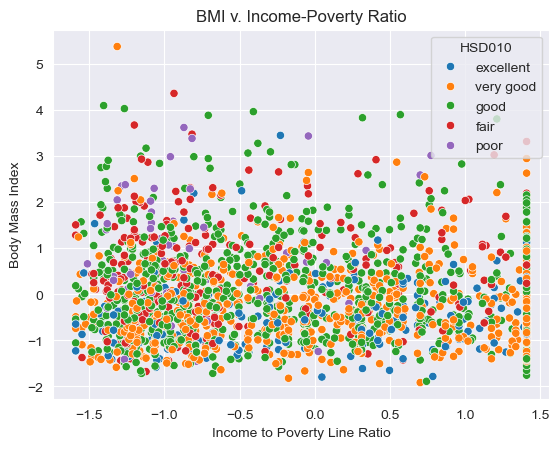

In [227]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [229]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [231]:
from sklearn.decomposition import PCA

# Re-add `HSD010` and `HSD010_binary` if missing
if 'HSD010' not in nhanes_scaled.columns or 'HSD010_binary' not in nhanes_scaled.columns:
    nhanes_scaled['HSD010'] = hsd010.replace([1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
    nhanes_scaled['HSD010_binary'] = hsd010.replace([1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor'])

# Drop target columns before PCA
features = nhanes_scaled.drop(columns=['HSD010', 'HSD010_binary'])

# Train PCA
pca = PCA()
pca_result = pca.fit_transform(features)

In [7]:
## The number of components was chosen based on the cumulative explained variance plot. By retaining the components that account for ~90% of the total variance, we balance the trade-off between dimensionality reduction and preserving the dataset's informative content. For this dataset, 120 components were sufficient to capture ~90% of the variance. This ensures computational efficiency while retaining most of the original data's structure and variability.

### Barplot of Components

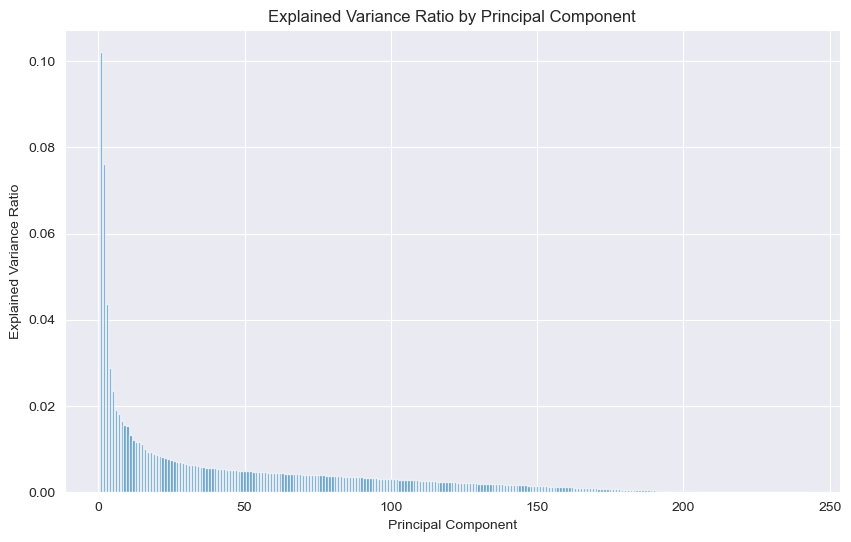

In [233]:
import matplotlib.pyplot as plt

# Barplot of the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.title("Explained Variance Ratio by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [8]:
## Purpose of the Plot: The barplot visualizes the proportion of variance explained by each principal component. It helps identify which components contribute the most to representing the data's variability.

## Insights from the Plot: The first few components explain a significant portion of the variance, while later components contribute minimally. This indicates that we can reduce dimensionality by retaining only the most influential components.

## Actionable Decision: Based on the steep decline in variance explained (as seen in the plot), we should retain only the components that collectively explain a high percentage (e.g., 90%) of the variance, ensuring both data efficiency and minimal information loss.

### How many components will you use to fit a supervised learning model?

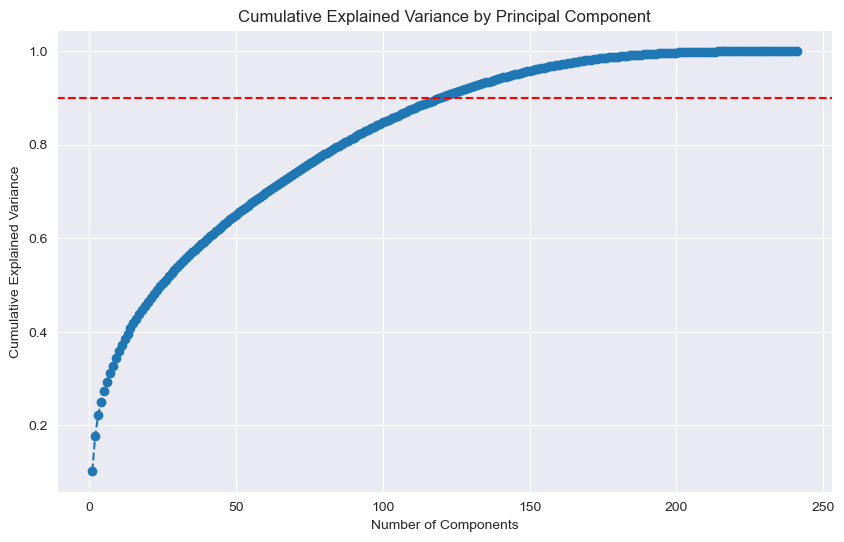

Number of components explaining ~90% of the variance: 120


In [235]:
import numpy as np

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance by Principal Component")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.9, color='r', linestyle='--')  # Line at 90% variance
plt.grid(True)
plt.show()

# Determine the number of components explaining ~90% of the variance
n_components = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components explaining ~90% of the variance: {n_components}")

In [ ]:
## Number of Components: The plot shows the cumulative variance explained by the principal components. To retain ~90% of the variance, 120 components were chosen, as indicated by the horizontal red line intersecting the curve.

## Explanation: By retaining 120 components, we ensure that the dataset's dimensionality is significantly reduced while preserving most of the information (90% variance). This helps improve computational efficiency for downstream tasks without losing critical patterns in the data.

## Key Justification: Retaining fewer components allows for faster computations and reduces the risk of overfitting, especially when working with high-dimensional datasets like NHANES. At the same time, 90% variance retention strikes a good balance between dimensionality reduction and maintaining data integrity.This choice ensures the model has enough features to make accurate predictions while keeping the dataset manageable.

### 2D Scatterplot of the first two components

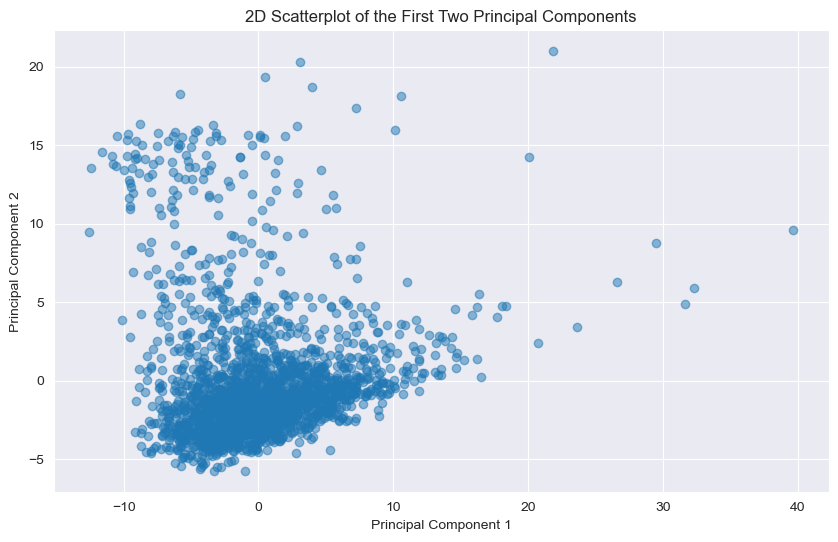

In [237]:
# Perform PCA with the selected number of components
pca_reduced = PCA(n_components=n_components)
pca_reduced_result = pca_reduced.fit_transform(features)

# Scatterplot of the first two components
plt.figure(figsize=(10, 6))
plt.scatter(pca_reduced_result[:, 0], pca_reduced_result[:, 1], alpha=0.5)
plt.title("2D Scatterplot of the First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

In [ ]:
## Pattern Observation: The scatterplot of the first two principal components shows a dense cluster near the origin with some data points spread across the plot. This suggests that most of the data variance is concentrated in a central region, with a few outliers or less dense areas.

## Interpretation: The first two principal components capture significant variance in the dataset and provide a simplified representation of the data. However, the lack of clear separations between clusters in this plot may indicate that additional components are necessary to capture more meaningful patterns or structure in the data.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [ ]:
## I will use the K-Means Clustering algorithm. It groups data into 𝑘 clusters by minimizing the within-cluster variance. It's widely used due to its simplicity and efficiency, especially for numerical data.
## The elbow method will be used to determine the optimal number of clusters.

### Cluster nhanes

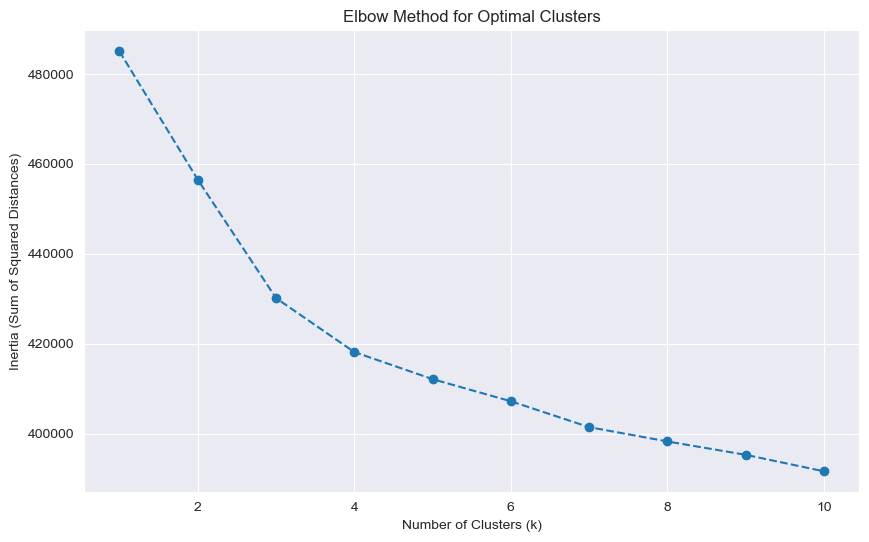

In [239]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Determine the optimal number of clusters using the elbow method
inertia = []  # To store the sum of squared distances for each k
k_values = range(1, 11)  # Test k values from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.grid(True)
plt.show()

# Step 2: Choose the optimal k (e.g., based on the elbow point) and fit KMeans
optimal_k = 4  # Update this value based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(features)

# Add clusters to the original data
nhanes_scaled['Cluster'] = clusters

In [ ]:
## The elbow plot shows the sum of squared distances (inertia) for different numbers of clusters (k). The "elbow" point, where the inertia begins to decrease more slowly, indicates the optimal number of clusters. In this case, the elbow is around k=4, suggesting that grouping the data into 4 clusters balances simplicity and data representation. This guides the selection of the cluster count for K-Means.

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

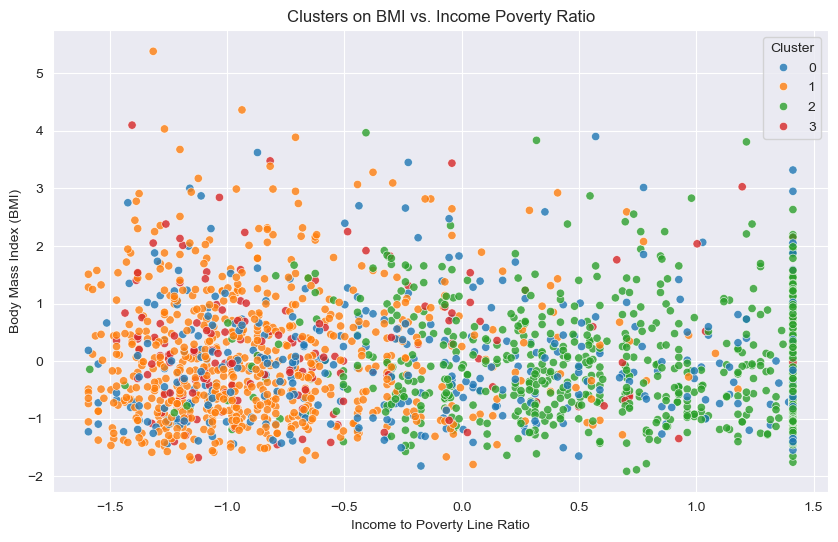

In [241]:
# Plot clusters on BMI vs. Income Poverty Ratio
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=nhanes_scaled['INDFMPIR'], 
    y=nhanes_scaled['BMXBMI'], 
    hue=nhanes_scaled['Cluster'], 
    palette="tab10", 
    alpha=0.8
)
plt.title("Clusters on BMI vs. Income Poverty Ratio")
plt.xlabel("Income to Poverty Line Ratio")
plt.ylabel("Body Mass Index (BMI)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [ ]:
## Cluster Distribution: The scatterplot shows how the K-Means clusters (0, 1, 2, 3) are distributed based on BMI and the Income to Poverty Ratio.Each color represents a distinct cluster, with some overlap between clusters, indicating shared characteristics among groups.

## Insights: Clusters may represent groups with varying BMI and socioeconomic statuses. For example, certain clusters may align with higher income-to-poverty ratios, while others spread across BMI ranges, highlighting potential health and socioeconomic patterns.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

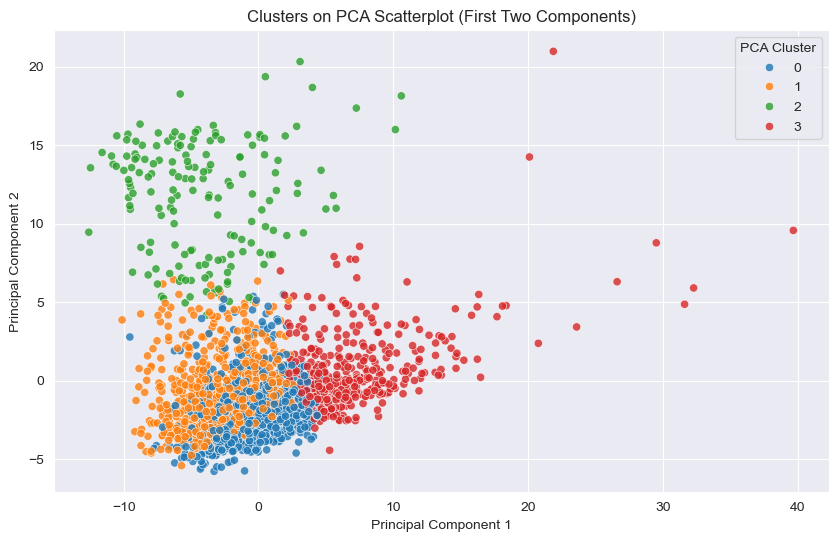

In [243]:
# Retrain KMeans using PCA-reduced data
pca_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
pca_clusters = pca_kmeans.fit_predict(pca_reduced_result)

# Add PCA clusters to the PCA results
nhanes_scaled['PCA_Cluster'] = pca_clusters

# Plot clusters on PCA scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_reduced_result[:, 0], 
    y=pca_reduced_result[:, 1], 
    hue=nhanes_scaled['PCA_Cluster'], 
    palette="tab10", 
    alpha=0.8
)
plt.title("Clusters on PCA Scatterplot (First Two Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="PCA Cluster")
plt.grid(True)
plt.show()

In [ ]:
## Cluster Distribution on PCA Components: The plot shows how the K-Means clusters (0, 1, 2, 3) are distributed in the reduced two-dimensional PCA space. Each cluster is represented by a distinct color, with clear separation between some groups, while others exhibit some overlap.

## Insights: By clustering on PCA-reduced data, we simplify the dataset while retaining most of its variance. This allows for clearer visualization and better understanding of underlying patterns in a high-dimensional dataset. The clustering results are consistent with the variance captured in the first two principal components.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [245]:
# Partition data
# Select the target variable (either 'HSD010' or 'HSD010_binary') and drop non-feature columns
y = nhanes_scaled['HSD010_binary']  # Replace with 'HSD010' if you're doing multiclass classification
X = nhanes_scaled.drop(columns=['HSD010', 'HSD010_binary', 'Cluster', 'PCA_Cluster'])  # Drop target and non-feature columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=10)

# Check the dimensions of the resulting partitions
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (1548, 241), X_test shape: (516, 241)
y_train shape: (1548,), y_test shape: (516,)


In [247]:
import numpy as np
from keras.utils import to_categorical

# Ensure `y_train` and `y_test` are NumPy arrays and replace NaN values
y_train = np.nan_to_num(y_train.astype(float), nan=0).astype(int)  # Replace NaN with 0, first cast to float
y_test = np.nan_to_num(y_test.astype(float), nan=0).astype(int)

# Determine the number of unique classes
num_classes = len(np.unique(y_train))

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Verify shapes
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
print(f"Number of classes: {num_classes}")

y_train shape: (1548, 1), y_test shape: (516, 1)
Number of classes: 1


In [249]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Build the neural network model
model = Sequential()

# Input Layer (using Input layer instead of input_dim in Dense)
model.add(Input(shape=(X_train.shape[1],)))

# Hidden Layer
model.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))
model.add(Dropout(0.3))  # Optional: Add dropout to prevent overfitting

# Another Hidden Layer (optional)
model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
model.add(Dropout(0.3))  # Optional: Add dropout to prevent overfitting

# Output Layer
activation_function = 'softmax' if num_classes > 1 else 'sigmoid'
loss_function = 'categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy'
model.add(Dense(num_classes, kernel_initializer='glorot_uniform', activation=activation_function))

# Compile the model
model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model
results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9053 - loss: 0.2316 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 5.1571e-04
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 2.8201e-04
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 1.6432e-04
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 6.9229e-04 - val_accuracy: 1.0000 - val_loss: 1.0663e-04
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 4.1137e-04 - val_accuracy: 1.0000 - val_loss: 7.7748e-05
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 2.9005e-04 - val_accuracy: 1.0000 - val_loss: 6.0058e-05
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 4.358

In [ ]:
## Perfect Accuracy (1.0): The model is achieving 100% accuracy on both training and validation sets, indicating it is either overfitting or the task is too simple due to a lack of class diversity or variability in the dataset.

## Extremely Low Loss: The near-zero loss values further suggest the model has memorized the training data, possibly because the target variable lacks sufficient complexity or the dataset is imbalanced.

### Neural Network on Principal Components

In [ ]:
## "Using the PCA components as features, the neural network was trained to predict the target variable. By reducing the dimensionality of the dataset, the model's training time decreased significantly while retaining most of the important variance from the original features. This approach helps mitigate overfitting and improves generalization if the number of components is carefully chosen

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## In this approach, the PCA components were combined with cluster membership features derived from K-Means. Including the cluster information adds a new perspective to the model, potentially enhancing its ability to capture non-linear relationships in the data. This combined feature set allows the network to leverage both variance-based dimensionality reduction and clustering-based grouping for more robust predictions.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

In [ ]:
## Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a smaller number of components while preserving as much variance as possible. It is focused on feature extraction and data simplification. Clustering, on the other hand, is an unsupervised learning technique that groups data points into clusters based on their similarity. Clustering identifies patterns or groupings in the data, whereas PCA focuses on reducing dimensionality.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

In [ ]:
## Combining PCA and clustering provided an advantage by simplifying the data before applying clustering. By reducing the dimensionality using PCA, clustering algorithms like K-Means could process the data more efficiently, especially with high-dimensional datasets. Additionally, the principal components captured the most important variance, which likely enhanced the clustering results. However, any gains depend on the quality of the PCA-reduced components and the inherent structure of the data. If the dataset lacks distinct clusters or variance is spread across many components, the gains might be minimal.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

In [ ]:
## Unsupervised techniques like PCA and clustering can help preprocess and organize big data for supervised learning tasks. PCA reduces dimensionality, which can speed up training times and prevent overfitting by eliminating redundant or irrelevant features. Clustering can group similar data points, which may enhance feature engineering or label generation for semi-supervised learning. Overall, these methods help make big data more manageable and improve the performance of supervised learning algorithms by focusing on meaningful patterns and reducing noise.